In [ ]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [ ]:
!pip -q install razdel networkx pymorphy2 nltk rouge==0.3.1 summa

     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 8.2 MB 9.1 MB/s 


## Dataset

In [ ]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [ ]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [ ]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

## Extractive RNN

### BPE

In [ ]:
!pip install youtokentome

     |████████████████████████████████| 1.7 MB 4.2 MB/s 


In [ ]:
import youtokentome as yttm

def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

In [ ]:
bpe_processor = yttm.BPE('BPE_model.bin')
vocabulary = bpe_processor.vocab()

In [ ]:
from rouge import Rouge
import razdel
from tqdm.notebook import tqdm

import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()

    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
import random
import math
import razdel
import torch
import numpy as np
from rouge import Rouge


class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device

    def __len__(self):
        return self.batches_count

    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:

                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)

                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:
                    sentences_indicies = record["oracle_sentences"]

                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))

                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            tensor_outputs = torch.zeros((self.batch_size, max_sentences), dtype=torch.float32, device=self.device)
            tensor_outputs += 2

            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [ ]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 32, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, 32, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)

## Extractor -  SummaRuNNer
 https://arxiv.org/pdf/1611.04230.pdf


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=False,
                 token_embedding_dim=128,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=2,
                 dropout=0.3):

        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.num_directions = num_directions

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers,
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)

        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)

        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.novelty_linear_layer =  nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()

        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, hidden_size]

        # W * h^T
        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2) # 1-representation
        # [batch_size, seq num]

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2) # 2-representation
        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            predictions = content + salience
            summary_representation = torch.zeros([batch_size, self.hidden_size*self.num_directions]).to(device)
            novelty = torch.zeros([batch_size, sentences_count]).to(device)

            for sentence_num in range(sentences_count):
                sentence_num_state = outputs[:, sentence_num, :]
                novel = - torch.bmm(sentence_num_state.unsqueeze(1), self.novelty_linear_layer(self.tanh_layer(summary_representation)).unsqueeze(2)).squeeze(2)
                novelty_to_predictions = predictions[:, sentence_num].unsqueeze(1) + novel
                probability = nn.Sigmoid()(novelty_to_predictions)
                summary_representation += torch.bmm(probability.unsqueeze(2), sentence_num_state.unsqueeze(1)).squeeze(1)

                novelty[:, sentence_num] = novel.squeeze(1)


        return content + salience + novelty

In [ ]:
vocab_size = len(vocabulary)
model_1 = SentenceTaggerRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model_1.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 2927617


In [ ]:
for name, param in model_1.named_parameters():
    print(f"{name}: {param.numel()}")

sentence_encoder.embedding_layer.weight: 1280000
sentence_encoder.rnn_layer.weight_ih_l0: 65536
sentence_encoder.rnn_layer.weight_hh_l0: 65536
sentence_encoder.rnn_layer.bias_ih_l0: 512
sentence_encoder.rnn_layer.bias_hh_l0: 512
sentence_encoder.rnn_layer.weight_ih_l0_reverse: 65536
sentence_encoder.rnn_layer.weight_hh_l0_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l0_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l0_reverse: 512
sentence_encoder.rnn_layer.weight_ih_l1: 131072
sentence_encoder.rnn_layer.weight_hh_l1: 65536
sentence_encoder.rnn_layer.bias_ih_l1: 512
sentence_encoder.rnn_layer.bias_hh_l1: 512
sentence_encoder.rnn_layer.weight_ih_l1_reverse: 131072
sentence_encoder.rnn_layer.weight_hh_l1_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l1_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l1_reverse: 512
rnn_layer.weight_ih_l0: 131072
rnn_layer.weight_hh_l0: 65536
rnn_layer.bias_ih_l0: 512
rnn_layer.bias_hh_l0: 512
rnn_layer.weight_ih_l0_reverse: 131072
rnn_layer.wei

In [ ]:
# !gdown https://drive.google.com/uc?id=1MiS_iczALcyF7zGDPY6niyeD82P0_PBH -O train_model.py
# !gdown https://drive.google.com/uc?id=1RwFqKfXLZp_P3FoGnLAcorQWNwW9-RtO -O train_model.py
!gdown https://drive.google.com/uc?id=1mso-R81QS-DdWvNm2Z3bsMtEDck4pUDN -O train_model.py
import train_model
import imp
imp.reload(train_model)
from train_model import train_with_logs

Downloading...
From: https://drive.google.com/uc?id=1mso-R81QS-DdWvNm2Z3bsMtEDck4pUDN
To: /content/train_model.py
100% 4.87k/4.87k [00:00<00:00, 4.34MB/s]


In [ ]:
N_EPOCHS = 3
CLIP = 1

def train(model, use_class_weights, N_EPOCHS, CLIP, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr)
    if use_class_weights:
        outp_one = []
        outp_zero = []
        lenght_sum = 0
        for iter in train_iterator:
          outp_one += torch.masked_select(iter['outputs'], iter['outputs'] == 1).cpu().numpy().tolist()
          outp_zero += torch.masked_select(iter['outputs'], iter['outputs'] == 0).cpu().numpy().tolist()

        lenght_sum += len(outp_one) + len(outp_zero)

        weights = torch.Tensor([len(outp_one)/lenght_sum, len(outp_zero)/lenght_sum])
        criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=2)
        train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=2)
        train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

## Inference

In [ ]:
from train_model import punct_detokenize, postprocess

def inference_summarunner(model, iterator, top_k=3, threshold=0):

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:

        logits = model(batch['inputs'])
        if top_k:
          sum_in = torch.argsort(logits, dim=1)[:, -top_k:]

        for i in range(len(batch['outputs'])):

            summary = batch['records'][i]['summary'].lower()
            if top_k:
              pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i]])
            else:
              sum_in = torch.nonzero((logits[i]>threshold).int(), as_tuple=True)[0]
              sents = batch['records'][i]['sentences']
              pred_summary = ' '.join([sents[ind] for ind in sum_in if ind < len(sents)])

            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

## Обучение без весов в CrossEntropyLoss и без Novelty

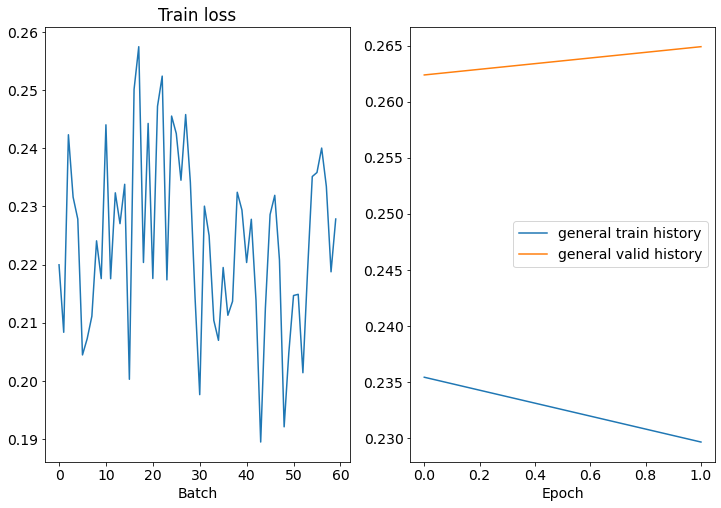

Epoch: 03 | Time: 5m 52s
	Train Loss: 0.224 | Train PPL:   1.251
	 Val. Loss: 0.273 |  Val. PPL:   1.314


In [ ]:
train(model_1, False, N_EPOCHS, CLIP)

### Inference с ранжированием logits без весов в CrossEntropyLoss и без Novelty

In [ ]:
model_1.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_1, test_iterator, 3)

Count: 256
Ref: в крыму полет американского беспилотника над границами полуострова назвали наглость . там также посоветовали узнавать всю необходимую информацию о регионе через официальную делегацию , которую можно было бы послать в крым , согласовав детали с российским внешнеполитическим ведомством . беспилотный летательный аппарат ввс сша пролетел в этом месте уже как минимум во второй раз за этот месяц .
Hyp: в крыму пролет американского беспилотника над полуостровом назвали наглостью . такое мнение выразил сопредседатель ассамблеи славянских народов крыма роман чегринец . « подобные полеты — это наглость , которая в очередной раз показывает всему миру двуличность и лицемерие внешней политики сша » , — сказал чегринец в комментарии риа « новости » .
BLEU:  0.44754274522966964
ROUGE:  {'rouge-1': {'f': 0.3157982758597188, 'p': 0.3031501649619639, 'r': 0.3488776502268287}, 'rouge-2': {'f': 0.14239895257305368, 'p': 0.1346895643218683, 'r': 0.16187862317861018}, 'rouge-l': {'f': 0.2725

### Inference с logits>0 без весов в CrossEntropyLoss и без Novelty

In [ ]:
model_1.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_1, test_iterator, 0)

Count: 256
Ref: украина может остаться без финансовой помощи евросоюза , если продолжит поддерживать позицию сша по газопроводу « северный поток — 2 » . об этом заявили в немецком бундестаге . если будут введены ограничения против « потока » , то германия может ввести ответные санкции .
Hyp: украине указали на ее место в споре по российскому газопроводу « северный поток — 2 » . об этом заявил риа « новости » глава комиссии по экономике и энергетике бундестага фрг клаус эрнст . действия украины по « сп-2 » парламентарий назвал неприемлемыми . германия может принять ответные меры , если сша введут санкции против « северного потока — 2 » , добавил эрнст . например , повысить пошлины на американский газ . поводом для такого выступления стало заявление заместителя главы мид украины елены зеркаль , заявившей , что киев хочет использовать американские санкции против трубопровода « сп-2 » как инструмент давления при переговорах по транзиту российского газа . санкции сша могут препятствовать за

## Обучение без весов в CrossEntropyLoss c Novelty

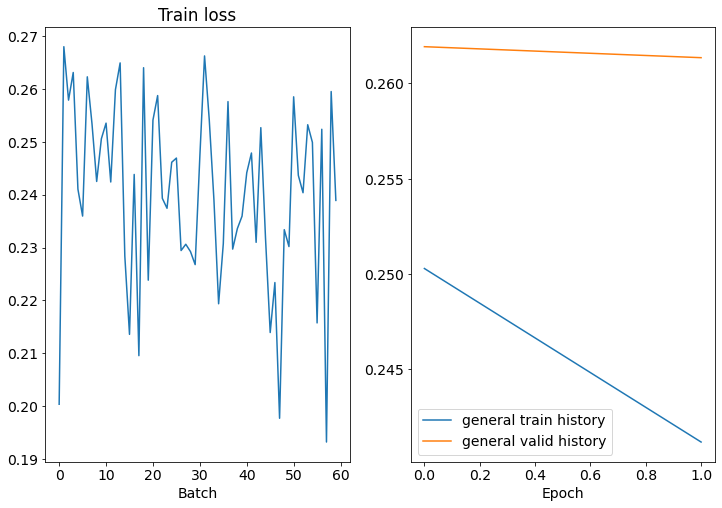

Epoch: 03 | Time: 5m 33s
	Train Loss: 0.239 | Train PPL:   1.270
	 Val. Loss: 0.267 |  Val. PPL:   1.306


In [ ]:
model_1_Novelty = SentenceTaggerRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model_1_Novelty.parameters() if p.requires_grad])

train(model_1_Novelty, False, N_EPOCHS, CLIP)

### Inference с ранжированием logits без весов в CrossEntropyLoss c Novelty

In [ ]:
model_1_Novelty.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_1_Novelty, test_iterator, 3)

Count: 256
Ref: 63-летний мужчина устроил стрельбу в центре калининграда и убил супружескую пару , а также ранил их сына . причем женщина была беременна и , как сообщают очевидцы , звала на помощь , но злоумышленник выстрелил в нее еще раз , добив ее . сам же стрелявший пытался покончить собой и умер в реанимации . предварительной версией конфликта стало место на местном центральном рынке .
Hyp: в центре калининграда мужчина открыл стрельбу из охотничьего карабина . он убил двоих , сообщает тасс со ссылкой на источник в правоохранительных органах . « по предварительным данным , мужчина открыл огонь по прохожим из нарезного охотничьего оружия .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.3173318124753692, 'p': 0.30313415143950345, 'r': 0.3531967563454288}, 'rouge-2': {'f': 0.1427732219026844, 'p': 0.1347593218711489, 'r': 0.16339726182715184}, 'rouge-l': {'f': 0.27154623032757474, 'p': 0.2739258120398611, 'r': 0.3186041265424391}}


### Inference с logits>0 без весов в CrossEntropyLoss c Novelty

In [ ]:
model_1_Novelty.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_1_Novelty, test_iterator, 0)

Count: 256
Ref: семь жителей самары , в том числе трое детей , пострадали в результате хлопка газа в частном доме , сообщает региональный главк мчс . по предварительным данным , вечером 3 марта в данном помещении праздновался день рождения — во время торжества внезапно взорвался газовый котел , из-за чего произошло обрушение крыши и стен . сотрудники экстренных служб доставали людей из-под завалов . нескольких пострадавших уже госпитализировали .
Hyp: семь человек , в том числе трое детей , пострадали в результате взрыва газа в жилом доме в самаре , сообщает тасс со ссылкой на пресс-службу регионального главка мчс . по предварительным данным , в этом частном двухэтажном доме на улице арцыбушевской проживали несколько семей с детьми , приехавших в самару из республик средней азии . по предварительным данным , в этом частном двухэтажном доме на улице арцыбушевской проживали несколько семей с детьми , приехавших в самару из республик средней азии . в тот день они праздновали день рождения

## Обучение с весами в CrossEntropyLoss без Novelty

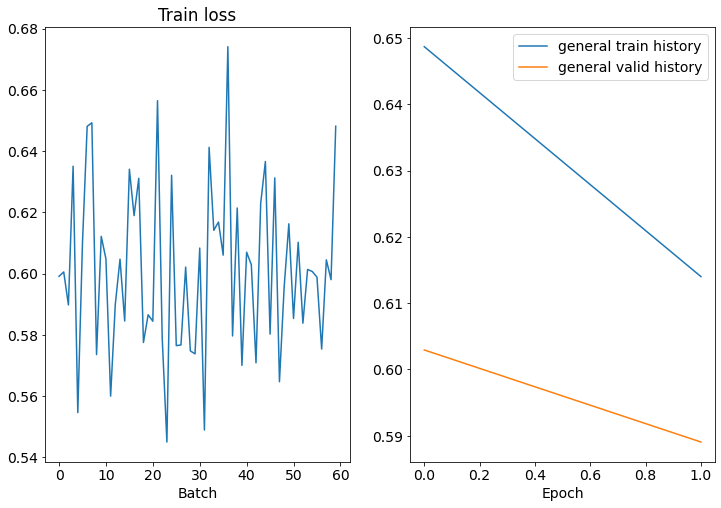

Epoch: 03 | Time: 5m 32s
	Train Loss: 0.601 | Train PPL:   1.825
	 Val. Loss: 0.589 |  Val. PPL:   1.802


In [ ]:
model_w = SentenceTaggerRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model_w.parameters() if p.requires_grad])
train(model_w, True, N_EPOCHS, CLIP)

### Inference с ранжированием logits с весами в CrossEntropyLoss без Novelty

In [ ]:
model_w.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_w, test_iterator, 3)

Count: 256
Ref: « бавария » все-таки уволила хорватского специалиста нико ковача , под руководством которого выиграла бундеслигу в прошлом сезоне . теперь , по информации прессы , в мюнхенском клубе выбирают нового главного тренера между жозе моуринью и арсеном венгером .
Hyp: нико ковач пришел в « баварию » в качестве главного тренера перед сезоном-2018/19 . в первый же год под его руководством клуб оформил дубль на внутренней арене в германии , выиграв чемпионат страны и кубок германии , где в финале со счетом 3 : 0 был разгромлен занявший в бундеслиге третье место « рб лейпциг » . и дело здесь было далеко не только в вылете в 1/8 финала лиги чемпионов , когда в ответном матче мюнхенцы были буквально сметены английским « ливерпулем » ( 3 : 1 ) , в итоге завоевавшим главный клубный трофей европы , хотя , конечно , окончание борьбы на столь ранней стадии не может положительно влиять на перспективы наставника в таком клубе .
BLEU:  0.42426085115795986
ROUGE:  {'rouge-1': {'f': 0.3108859

### Inference с logits>0 с в CrossEntropyLoss без Novelty

In [ ]:
model_w.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_w, test_iterator, 0)

Count: 256
Ref: американские военные развернули военный лагерь seadragon вблизи от побережья аляски . спустя пять дней после этого над ним пролетели два дальних противолодочных самолета россии ту-142 . в качестве сопровождения к ним были приставлены истребители сша и канады .
Hyp: спустя пять дней после создания военного американского лагеря seadragon над ним пролетели два дальних противолодочных самолета россии ту-142 , передает popular mechanics . отмечается , что лагерь был развернут в море бофорта на расстоянии нескольких десятков километров от побережья аляски . издание задается вопросом , как российские самолеты обнаружили американский лагерь . но , пишет popular mechanics , ясно , что россия внимательно следит за действиями сша даже в арктике . инцидент произошел 9 марта , военные самолеты пролетели над ледовым лагерем сша на высоте порядка 760 метров . для их сопровождения в воздух были подняты американские истребители f-22 raptor и канадские cf-18 hornet . отмечается , что рос

## Обучение с весами в CrossEntropyLoss с Novelty

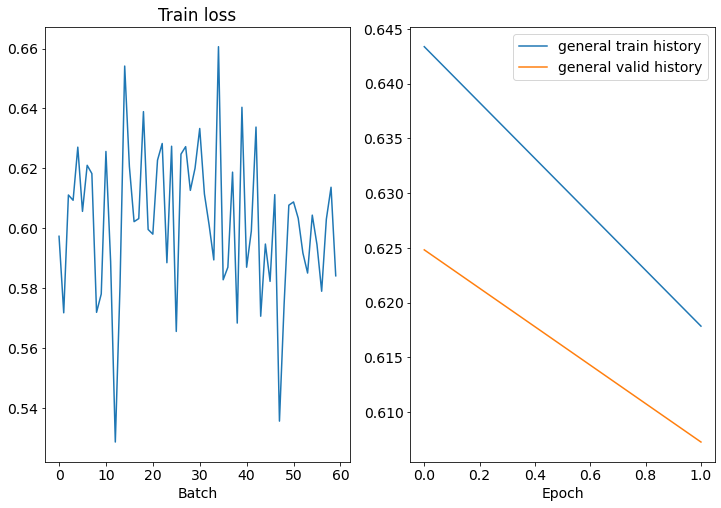

Epoch: 03 | Time: 5m 36s
	Train Loss: 0.602 | Train PPL:   1.826
	 Val. Loss: 0.595 |  Val. PPL:   1.814


In [ ]:
model_w_Novelty = SentenceTaggerRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model_w_Novelty.parameters() if p.requires_grad])
train(model_w_Novelty, True, N_EPOCHS, CLIP)

### Inference с ранжированием logits с весами в CrossEntropyLoss с Novelty

In [ ]:
model_w_Novelty.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_w_Novelty, test_iterator, 3)

Count: 256
Ref: в челябинской области скончалась многодетная мать , которую , предположительно , до смерти избил муж . по данным местных сми , которые ссылаются на родственников погибшей , мужчина проломил жене голову и свернул шею прямо на глазах у несовершеннолетних детей . тем не менее в полиции версию убийства не рассматривают — результаты экспертизы показали , что женщина умерла от инфаркта , в то время как травмы , нанесенные супругом , якобы были не опасны для жизни .
Hyp: в челябинской области 26-летняяя многодетная мать из города златоуста скончалась в результате конфликта с мужем . о случившемся сообщила депутат заксобрания области ольга мухометьярова . « жертвой мужа-тирана стала светлана , выпускница колледжа , где много лет назад я была руководителем .
BLEU:  0.4196100822469144
ROUGE:  {'rouge-1': {'f': 0.3034123945389835, 'p': 0.28168716838307606, 'r': 0.3494749134962305}, 'rouge-2': {'f': 0.13381869948659988, 'p': 0.1223542472290978, 'r': 0.15926872336316478}, 'rouge-l':

### Inference с logits>0 с в CrossEntropyLoss с Novelty

In [ ]:
model_w_Novelty.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_w_Novelty, test_iterator, 0)

Count: 256
Ref: предсказавший кризис 2008 года экономист джесси коломбо заявил , что миру грозит новая катастрофа . по мнению американского эксперта , сейчас на мировом финансовом рынке есть сразу несколько пузырей , которые могут лопнуть в любой момент . ситуацию усугубляют эпидемия коронавируса и развал сделки опек + .
Hyp: как сообщает the independent , новый крах рынков может оказаться гораздо сильнее того , что случился 12 лет назад . по мнению коломбо , сейчас на мировом рынке « надулось сразу несколько пузырей — и они могут лопнуть в любой момент » . кроме того , ситуацию усугубляют пандемия « смертельного китайского коронавируса , выплеснувшегося за пределы азии » и затяжной спад в мировой экономике — он начался « задолго до всего этого » . еще один негативный фактор , по словам экономиста — развал сделки опек + и рухнувшие до $ 30 за баррель цены на нефть . накануне аналитическое кредитное рейтинговое агентство ( акра ) опубликовало на официальном сайте показатели индекса фина

## Добавим несколько эпох и threshold (без весов в CrossEntropyLoss с Novelty)

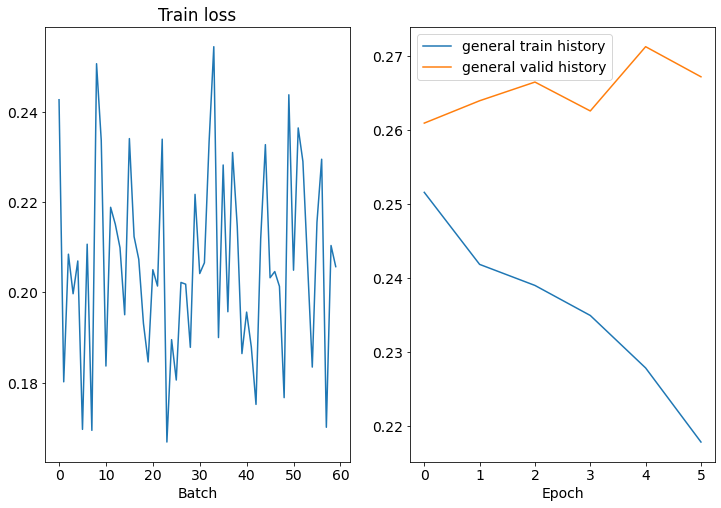

Epoch: 07 | Time: 6m 52s
	Train Loss: 0.207 | Train PPL:   1.230
	 Val. Loss: 0.287 |  Val. PPL:   1.332


In [ ]:
model = SentenceTaggerRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
train(model, False, 7, CLIP)

### Inference с threshold и большим количеством эпох

In [ ]:
model.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model, test_iterator, 0, threshold=-0.1)

Count: 256
Ref: в брюсселе завершились консультации россии , ес и украины по транзиту газа . перед этим по данному вопросу провели телефонные переговоры президент россии владимир путин и канцлер фрг ангелой меркель . соглашение заканчивается в конце года , и новое далеко от подписания . отказ « газпрома » от прокачки поставляемого в евросоюз газа через украину будет стоить киеву $ 3 млрд ежегодно .
Hyp: в брюсселе завершились трехсторонние консультации россии , украины и евросоюза по транзиту газа . главным вопросом в повестке стала судьба договора о транзите российского газа через украину . текущее соглашение истекает в конце нынешнего года .
BLEU:  0.4506697957105403
ROUGE:  {'rouge-1': {'f': 0.31745103420785425, 'p': 0.30871007881846985, 'r': 0.34934246774590616}, 'rouge-2': {'f': 0.14322248387897013, 'p': 0.1385488070445201, 'r': 0.16148574439346655}, 'rouge-l': {'f': 0.27036123841684534, 'p': 0.27849524662835007, 'r': 0.31450293445884586}}
